# PRÁCTICA 7.2: MINI-CHATBOT CON LLMS

En esta práctica vamos a abrir la caja negra de un Gran Modelo de Lenguaje (LLM). En lugar de usar APIs cerradas, como la de ChatGPT, vamos a usar un modelo open-source directamente en nuestro entorno usando **PyTorch** y **Hugging Face Transformers**.

## 0. Objetivos
1.  **Arquitectura Decoder-Only:** Entender por qué usamos la familia GPT/Qwen para chat y no modelos tipo BERT.
2.  **Probabilidad y Logits:** Visualizar la incertidumbre del modelo al predecir la siguiente palabra.
3.  **Algoritmos de Decodificación:** Comparar **Greedy Search**, **Beam Search** y **Sampling** (Top-P/Temperature).
4.  **Chat Templates Modernos:** Aprender cómo se estructuran los prompts hoy en día (Roles: System, User, Assistant).

## 1. El Modelo: Qwen 2.5 (1.5B Instruct)

Usaremos una versión ligera de **Qwen**, un modelo moderno (2024/2025) que supera a muchos modelos antiguos. Usaremos la variante `instruct`, ya que es el fine-tuning del modelo pre-entrenado para su uso en chat. Con 1,5 Billions (mil millones en español) de parámetros, es lo suficientemente pequeño para caber en la memoria de una GPU gratuita (T4) o incluso una CPU potente. Pero, ¿cómo podemos saber cuánta memoria ocupa a partir de su número de parámetros?

### 1.1. Cálculo de requisitos de memoria

La fórmula para saber la cantidad de memoria que ocupa la representación del modelo (todos sus parámetros/pesos), es muy sencilla: 

$$M \text{ (en Bytes)} = N \times P$$

Siendo $N$ el número de parámetros y $P$ la cantidad de bytes para representar un parámetro (por ejemplo, si estamos en FP32 serían 4 Bytes, o si es FP16, serían 2 Bytes). Para Qwen 1.5B Instruct, sería:

* Si usamos la carga estándar (FP16, con `dtype="auto"`): $1.5 \text{ Billions} \times 2 \text{ Bytes} = \mathbf{3.0 \text{ GB}}$
* Si usamos la carga pura (FP32, con `dtype=float32`): $1.5 \text{ Billions} \times 4 \text{ Bytes} = \mathbf{6.0 \text{ GB}}$

Sin embargo, no basta con tener 3 GB de VRAM (Device Memory en la GPU) para un modelo de 3 GB. Necesitas un margen extra para:
* **Optimizaciones para motores de inferencia modernos**. Esto incluye: Flash attention, carga de librería PyTorch/Transformers/CUDA, recomputación de activaciones, administración de memoria reutilizando buffers... Esto incurre entre un 20%-25% extra de memoria.
* **KV cache por token**. Para evitar recalcular las matrices K y V para los tokens intermedios en la ventana de contexto, se mantiene una caché. Esta caché es de tamaño: $$KV_{cache} = 2 \times P \times Layers \times D_{kv} \times \text{Sequence Length} \times \text{Batch Size}$$

donde: 
* 2 porque hay un vector para Key (K) y otro para Value (V).
* P: Precisión en bytes (2 bytes para FP16).
* Layers: Número de capas del modelo.
* $D_{kv}$: La dimensión oculta dedicada a KV.
* Sequence Length: Cuántos tokens hay en la conversación actual.

Para el caso concreto de Qwen2.5-1.5B, tenemos:
* Layers: 28
* Hidden Dimension ($D_{model}$): 1536
* Atención (GQA): Qwen usa *Grouped Query Attention (GQA)*. El modelo tiene 12 cabezales (head) de atención, pero solo 2 heads para KV. Esto significa que no guardamos una dimensión de 1536, sino mucho menos, por lo que tenemos $D_{head} = 1536 / 12 = 128$, y $D_{kv} = 128 \times 2 \text{ (KV heads)} = \mathbf{256}$

Finalmente, el cálculo de memoria por token es: $$2 \times 2 \text{ (bytes)} \times 28 \text{ (capas)} \times 256 \text{ (dim KV)} = 28.672 \text{ bytes/token}$$ Es decir, cada palabra escrita consume unos ~0,028 MB de VRAM de GPU. En conclusión, podemos seguir considerando que usaremos un 25% extra para chats normales: Si haces un bot para charlar un largo rato (1k-4k tokens), la caché es insignificante (100 MB vs 3000 MB del modelo). 

### 1.2 Instalación

Para reproducir esta práctica solo hace falta:

In [3]:
# 'accelerate' es necesaria para gestionar modelos grandes en la GPU eficientemente
!pip install transformers torch matplotlib accelerate

Defaulting to user installation because normal site-packages is not writeable


## 2. Carga del Modelo y Tokenizer

Vamos a cargar el modelo en la GPU (si está disponible). Como vimos en la práctica 6.4, desde el Hugging Face Hub podemos descargar tanto el modelo como su tokenizer. En el siguiente código lo hacemos:

In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt

# Nombre del modelo en Hugging Face Hub
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

print(f"Cargando modelo {model_name}...")

# 1. Cargar el Tokenizer correspondiente
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Cargar el Modelo
# torch_dtype="auto" selecciona float16 si hay GPU para ahorrar memoria RAM
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",     # Descargará los pesos en formato BFloat16
    device_map="auto" # Distribuye el modelo automáticamente
)

print("Modelo cargado!")

Usando dispositivo: cuda
Cargando modelo Qwen/Qwen2.5-1.5B-Instruct...


2025-12-04 15:23:27.355096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Modelo cargado!


## 2. Entendiendo qué "piensa" el modelo

Primero, debemos tener claro un concepto clave: el **Causal Language Modeling (CLM)**. A diferencia de cuando usamos un modelo como RoBERTa (que ve toda la frase a la vez para clasificarla), los modelos de chat son **Autoregresivos**. Predicen el token $w_t$ basándose únicamente en la historia previa $w_{1:t-1}$. Para ello se usa una distribución de probabilidad $P(\text{respuesta} | \text{historia})$. 

Además, el modelo no devuelve una sola palabra, devuelve un vector de **Logits** del tamaño de todo su vocabulario (aproximadamente 150.000 tokens en Qwen). Como ya has aprendido en este curso, al aplicar la función **Softmax**, convertimos esos logits en probabilidades que suman 1 (100%).

La siguiente función nos permite ver el "ranking" de palabras que el modelo está considerando para continuar una frase.

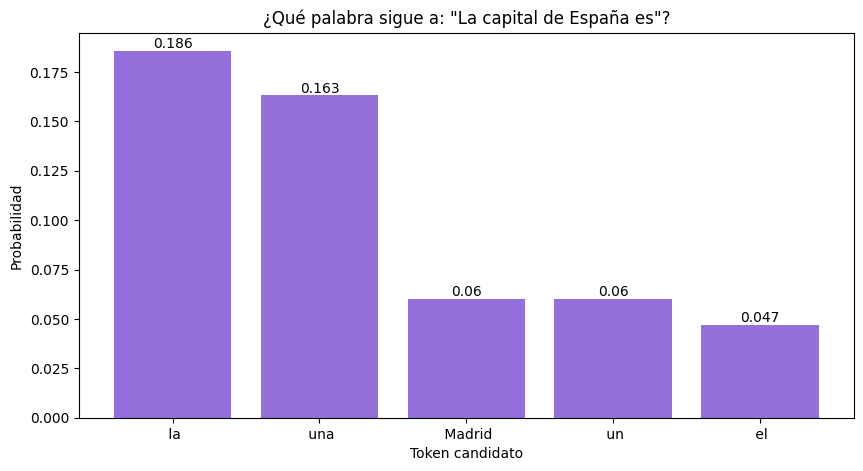

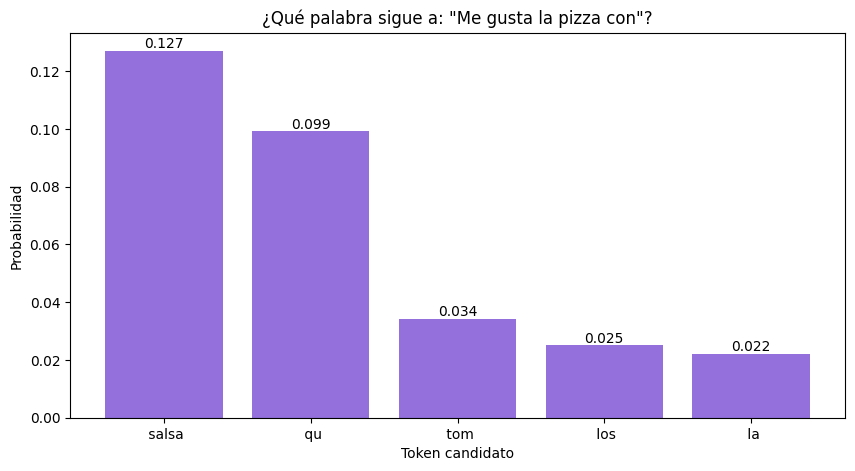

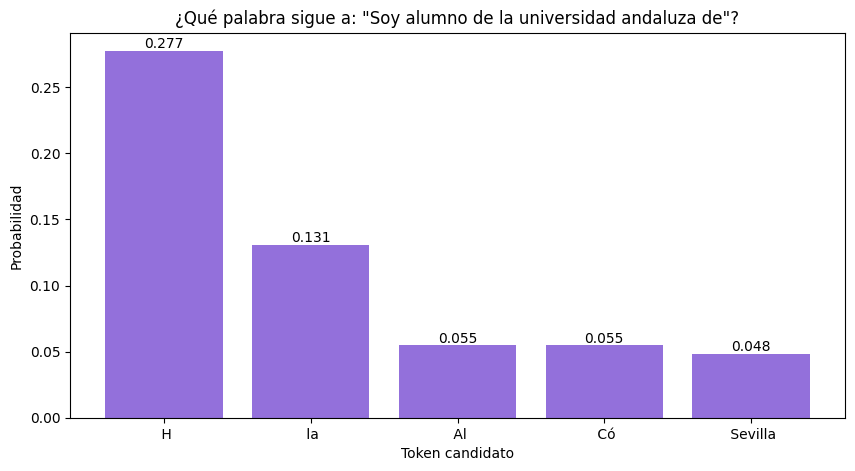

In [5]:
def visualizar_proxima_palabra(texto_input):
    # 1. Tokenizar: Convertir texto a números
    input_ids = tokenizer.encode(texto_input, return_tensors='pt').to(model.device)

    # 2. Inferencia (Forward pass)
    # Usamos torch.no_grad() porque no estamos entrenando
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits

    # 3. Miramos solo el último token generado (la predicción inmediata)
    last_token_logits = predictions[0, -1, :]

    # 4. Aplicar Softmax para obtener probabilidades (0.0 a 1.0)
    probs = F.softmax(last_token_logits, dim=-1)

    # 5. Obtener el Top 5 de candidatos
    top_probs, top_indices = torch.topk(probs, 5)

    # Decodificar los IDs a palabras para poder leerlos
    # Cuidado, Qwen tiene sus pesos en BFloat16, que no es compatible con Numpy,
    # Así que primero pasamos a float, y después a numpy
    top_probs = top_probs.float().cpu().numpy()
    top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

    # 6. Gráfico de barras
    plt.figure(figsize=(10, 5))
    bars = plt.bar(top_tokens, top_probs, color='mediumpurple')
    plt.title(f'¿Qué palabra sigue a: "{texto_input}"?')
    plt.ylabel('Probabilidad')
    plt.xlabel('Token candidato')
    
    # Añadir el valor encima de la barra
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')
        
    plt.show()

# Prueba con frases incompletas para ver la incertidumbre
visualizar_proxima_palabra("La capital de España es")
visualizar_proxima_palabra("Me gusta la pizza con")
visualizar_proxima_palabra("Soy alumno de la universidad andaluza de")

## 3. Estrategias de Decodificación

El gráfico anterior nos muestra las probabilidades, pero... ¿cómo elegimos una sola palabra para continuar? ¿Cómo construimos una respuesta completa concatenando tokens? A continuación veremos tres formas de hacerlo.

### A. Greedy Search (Búsqueda Avariciosa)
Esta es la estrategia más simple: Elegir siempre el token con mayor probabilidad (o top 1).

* **Ventaja:** Es rápida y determinista.
* **Desventaja:** El modelo no planifica a futuro. A veces elegir la palabra más probable ahora lleva a un callejón sin salida gramatical después, y otras veces provoca bucles infinitos ("me gusta jugar jugar jugar...").

Probémoslo:

In [6]:
input_text = "La inteligencia artificial es"
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)

# Generación Greedy (do_sample=False)
output_greedy = model.generate(
    input_ids,
    max_new_tokens=50,
    do_sample=False  # Desactiva la aleatoriedad
)

print("Greedy:", tokenizer.decode(output_greedy[0], skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Greedy: La inteligencia artificial es una de las tecnologías más avanzadas y prometedoras en el mundo actual. Sin embargo, su uso puede ser controvertido debido a la preocupación sobre los riesgos que implica para la privacidad y seguridad de los individ


### B. Beam Search (Búsqueda en Haz)

El **Beam Search** es la evolución lógica del Greedy Search. Mientras que el Greedy es "miope" (solo mira el siguiente paso), el Beam Search intenta encontrar la secuencia de palabras que maximice la probabilidad global de la frase completa. Para ello hace uso del concepto de "haz" (Beam), que son las $k$ frases candidatas con mejor puntuación. Se construye de la siguiente forma:

1. En lugar de elegir solo la mejor palabra inicial, se elige las $K$ mejores. Ahora tenemos $K$ frases candidatas iniciadas.
2. Para cada una de esas $K$ frases, se busca todas las posibles continuaciones. Para que el problema no explote en la cantidad de combinaciones resultantes, se realiza una poda (Pruning)calculando su puntuación acumulada y seleccionando solo las $K$ mejores. 
3. Se repite el paso 2 hasta encontrar el token de fin (<eos>).

Es interesante detallar cómo se calcula la *Probabilidad Acumulada (Score)* para seleccionar las mejores candidatas. El objetivo del modelo es encontrar la secuencia de palabras $Y = (y_1, y_2, ..., y_t)$ que maximice la probabilidad conjunta: $$P(Y) = P(y_1) \times P(y_2|y_1) \times P(y_3|y_{1:2}) \times \dots \times P(y_t|y_{1:t-1})$$ El problema es computacional, puesto que si multiplicas muchos números pequeños (p.ej: $0.9 \times 0.5 \times 0.1 \dots$), el resultado se acerca muy rápido a cero, causando errores de precisión (underflow). La solución es sencilla, trabajar con Log-Probabilities, es decir, los logaritmos de las probabilidades, por lo que en vez de trabajar multiplicando, simplemente sumamos. Por tanto, la fórmula que optimiza el Beam Search en cada paso es: $$\text{Score}(Y) = \sum_{i=1}^{t} \log P(y_i | y_{1:i-1})$$ 

En resumen, usar beam search conyeva mayor coherencia al mantener múltiples caminos abiertos, evitando caer en "callejones sin salida" donde una palabra parecía buena al principio pero hacía imposible terminar la frase gramaticalmente. Eso sí, esto viene con un incremento en el coste Computacional, puesto que es $K$ veces más lento y costoso en memoria que el Greedy Search. Sin embargo, aunque explora más opciones, siempre devuelve la misma respuesta para el mismo input (no hay azar). Por eso es el estándar en Traducción Automática, pero a veces resulta "seco" para Chatbots.

Probémoslo:

In [ ]:
# Generación con Beam Search
output_beam = model.generate(
    input_ids,
    max_new_tokens=50,
    num_beams=5,        # Mantiene las 5 mejores candidatas
    early_stopping=True
)

# Al final del proceso solo se devuelve la mejor secuencia
print("Beam Search:", tokenizer.decode(output_beam[0], skip_special_tokens=True))

Beam Search: La inteligencia artificial es una de las tecnologías más prometedoras en la actualidad, pero también es una de las más controvertidas. En este artículo, te explicamos qué es la inteligencia artificial y cuáles son sus ventajas y des


### C. Sampling (Muestreo Aleatorio)

Si siempre elegimos la palabra más probable (como en el *Greedy Search*), el texto resultante suele ser robótico, repetitivo y aburrido. Los humanos no hablamos así; a veces elegimos palabras inesperadas que aportan matices y algo de "chispa". Para solucionar esto, usamos **Sampling**: En lugar de elegir el top 1, el modelo lanza un dado (genera un número aleatorio) ponderado por las probabilidades para elegir la siguiente palabra. Sin embargo, lanzar el dado sin control puede generar frases sin sentido. Para domar el azar, usamos dos "palancas" fundamentales:
1. **Temperature** ($T$): Modificando la forma de la curva. La temperatura es un parámetro que escala los logits (puntuaciones) antes de convertirlos en probabilidades (Softmax). Matemáticamente, suaviza o afila la distribución: $$P_i = \frac{\exp(logit_i / T)}{\sum_j \exp(logit_j / T)}$$ 
* *Baja Temperatura* ($T < 1.0$): "Congela" la distribución y exagera las diferencias. Las palabras que ya eran probables se vuelven casi certeras (99%), y las opciones menos probables caen a 0. Por tanto, el modelo se vuelve conservador, muy lógico, preciso, pero repetitivo. Este modo es útil para tareas de programación, matemáticas o hechos factuales.
* *Alta Temperatura* ($T > 1.0$): "Derrite" la distribución aplanando las diferencias. Una palabra con un 1% de probabilidad podría subir al 10% o 15%. De esta forma, el modelo se arriesga más, es más creativo y diverso, pero si te pasas, empezará a decir incoherencias o **alucinaciones**. Esto tiene más uso en ámbitos como la poesía, lluvia de ideas, escritura creativa, etc.

2. **Top-P (Nucleus Sampling)**: Cortando *la cola larga*. Incluso con una temperatura adecuada, el vocabulario tiene miles de palabras con una probabilidad minúscula (0.0001%), muchas de las cuales son errores gramaticales o palabras fuera de contexto. Si tiramos el dado miles de veces, eventualmente caeremos en una de estas opciones malas. El Top-P es una estrategia de poda inteligente. En lugar de elegir entre todas las palabras, el modelo ordena las palabras de mayor a menor probabilidad, va sumando sus probabilidades acumuladas y corta la lista en cuanto la suma llega al umbral $P$ (por ejemplo, $0.90$ o 90%). ¿Por qué es mejor que el antiguo Top-K? Porque es dinámico. Si el modelo está seguro (p.ej: "El perro lad..."), la sílaba "ra" tiene un 99% de probabilidad. El Top-P selecciona solo 1 opción. Si el modelo duda (ej: "El color de la camisa es..."), hay muchas opciones válidas (rojo, azul, verde...). Para llegar al 90% de probabilidad acumulada, el Top-P mantendrá abiertas 20 opciones.

En resumen, la temperature define la "locura" o aleatoriedad, mientras que el Top-P es una red de seguridad que prohíbe elegir opciones absurdas (caer en la "cola larga" de la distribución).

In [11]:
# Generación con Sampling (Lo estándar para Chatbots)
output_sample = model.generate(
    input_ids,
    max_new_tokens=50,
    do_sample=True,      # Habilita el sampling
    top_p=0.90,          # Nucleus sampling (considera el 90% de masa de probabilidad)
    temperature=0.7      # Creatividad balanceada
)

print("Sampling:", tokenizer.decode(output_sample[0], skip_special_tokens=True))

Sampling: La inteligencia artificial es el futuro de la educación - Tecnología | EL TIEMPO
El presidente de Microsoft, Satya Nadella (izq.), durante una conferencia en Singapur. AFP
Publicado por: El Tiempo Digital · 28-


**Ejercicio:** prueba a subir el valor de temperatura, y luego también a bajarlo. También juega a aumentar el top_p. ¿Qué efectos ves en las respuestas?

In [23]:
output_sample = model.generate(
    input_ids,
    max_new_tokens=50,
    do_sample=True,      # Habilita el sampling
    top_p=0.90,          # Nucleus sampling (considera el 90% de masa de probabilidad)
    temperature=1.9      # Creatividad balanceada
)

print("Sampling:", tokenizer.decode(output_sample[0], skip_special_tokens=True))

Sampling: La inteligencia artificial es la ciencia de los sistemas y el desarrollo automático que se basan en modelos, datos y lenguajes de programación humanos a realizar tareas tradicionalemente manejadas solo por el organismo humano o serio computacion


## 4. Chatbot Moderno (Chat Templates)

Los modelos modernos como Qwen, Llama 4 o Mistral no esperan texto plano. Esperan una estructura de diálogo específica. 

Usaremos `tokenizer.apply_chat_template`, que se encarga de formatear la conversación automáticamente con los tokens especiales (ej. `<|im_start|>user ... <|im_end|>`).

**Roles:**
* **System:** Instrucciones ocultas que definen la personalidad del bot.
* **User:** Lo que escribes tú.
* **Assistant:** Lo que responde el modelo.


Hace unos años, para hablar con un modelo, simplemente se le pasaba un texto plano y "rezabas" para que siguiera la corriente.

* Input: "Hola, ¿cómo estás?"
* Output GPT-2: "dijo Juan al entrar en la habitación." (El modelo creía que estaba escribiendo una novela).

Los modelos modernos han sido entrenados específicamente para seguir instrucciones (Instruction Tuning). Para ello, necesitan distinguir claramente quién dice qué.

### A. La Estructura de Datos: Lista de Diccionarios

Actualmente en la industria (OpenAI API, Hugging Face, LangChain) se ha estandarizado el uso de una lista de objetos JSON. Esto permite mantener la memoria de forma ordenada.

In [ ]:
messages = [
    {"role": "system", "content": "Eres un profesor de matemáticas sarcástico."},
    {"role": "user", "content": "¿Cuánto es 2+2?"},
    {"role": "assistant", "content": "Pues 4, obviamente. ¿Necesitas ayuda con algo más difícil?"},
    {"role": "user", "content": "Explícame las integrales."}
]

### B. Los 3 Roles Fundamentales
El modelo necesita contexto. No es lo mismo lo que dices tú, que lo que dijo él antes, que las *instrucciones de fábrica*.

* **System (Sistema)**: Es el "director de la obra". El usuario final no suele ver este mensaje, pero condiciona todo el comportamiento del bot. Aquí defines la personalidad, las restricciones (ej: "no uses palabrotas") y el formato de salida.
* **User (Usuario)**: Son las entradas o **prompts** que escribes tú (el humano).
* **Assistant (Asistente)**: Son las respuestas previas del modelo. Esto es crucial para que el modelo mantenta una memoria, ya que los modelos de transformers no tienen memoria real. En cada turno, le volvemos a enviar toda la conversación anterior (incluyendo sus propias respuestas marcadas como "assistant") para que sepa de qué estábamos hablando.

### C. Plantillas de chat

Sin embargo, el modelo neuronal no entiende de diccionarios ni JSON. Solo entiende texto plano (tokens). Es por ello que la función tokenizer.apply_chat_template(messages) traduce este diccionario a una cadena de texto cruda llena de Tokens Especiales. Por ejemplo, esto es lo que verá Qwen si le pasas el diccionario de antes:

```<|im_start|>system
Eres un profesor de matemáticas sarcástico.<|im_end|>
<|im_start|>user
¿Cuánto es 2+2?<|im_end|>
<|im_start|>assistant
Pues 4, obviamente.<|im_end|>
<|im_start|>user
Explícame las integrales.<|im_end|>
<|im_start|>assistant```



Esto es importante porque cada modelo usa sus propios separadores (`<|im_start|>`, `[INST]`, `<|eot_id|>`). Sería muy complejo hacerlo a mano, por lo que `apply_chat_template` busca automáticamente qué formato usa el modelo que has cargado y lo aplica por ti.

**Ejercicio**: prueba a codificar distintos mensajes en el código siguiente:

In [27]:
print("--- INTERIOR DEL LLM ---")
mensajes_prueba = [
    {"role": "system", "content": "Eres un asistente útil."},
    {"role": "user", "content": "Hola mundo"}
]

# Convertimos la lista a string plano usando la plantilla
prompt_crudo = tokenizer.apply_chat_template(
    mensajes_prueba,
    tokenize=False, # Lo pedimos en texto para poder leerlo
    add_generation_prompt=True
)

print(prompt_crudo)
print("------------------------")

--- INTERIOR DEL LLM ---
<|im_start|>system
Eres un asistente útil.<|im_end|>
<|im_start|>user
Hola mundo<|im_end|>
<|im_start|>assistant

------------------------


## 5. Chatbot

Ya tenemos todos los ingredientes para construir nuestro chatbot personalizado. Tómate un momento para inspeccionar la función siguiente, y juega con el modelo tal y como lo harías con ChatGPT o Gemini. Por supuesto, no vas a recibir respuestas tan buenas, ya que el modelo es muy pequeño, pero recuerda que esto se está ejecutando para ti solo en una sola GPU/CPU.

In [28]:
def chat_con_qwen():
    print("Qwen: ¡Hola! Soy tu asistente de IA. Escribe 'salir' para terminar.")
    print("------------------------------------------------------------------")

    # Historial inicial: Definimos la personalidad del sistema
    messages = [
        {"role": "system", "content": "Eres un asistente útil, amable y experto en inteligencia aritificial. Respondes en español."}
    ]

    while True:
        # 1. Entrada del usuario
        user_input = input(">> Tú: ")
        if user_input.lower() in ["salir", "exit", "quit"]:
            break

        # 2. Añadir al historial
        messages.append({"role": "user", "content": user_input})

        # 3. Aplicar CHAT TEMPLATE
        # Convierte la lista de diccionarios en el string formateado que espera el modelo
        text_input = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # 4. Tokenizar y Mover a GPU
        model_inputs = tokenizer([text_input], return_tensors="pt").to(model.device)

        # 5. Generar respuesta (Usando Sampling)
        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=512,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )

        # 6. Decodificar solo la parte nueva
        # Qwen devuelve [input + output], así que recortamos el input
        generated_ids = [ 
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]
        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        print(f"Qwen: {response}")

        # 7. Actualizar memoria del bot con su propia respuesta
        messages.append({"role": "assistant", "content": response})

# Hora de probarlo!
chat_con_qwen()

Qwen: ¡Hola! Soy tu asistente de IA. Escribe 'salir' para terminar.
------------------------------------------------------------------
Qwen: ¡Hola! Soy una inteligencia artificial diseñada para ayudar tanto a estudiantes como profesores con información sobre ciertos temas. En este caso, estoy aquí para proporcionarte información relevante acerca del aprendizaje profundo, especialmente si estás haciendo referencia al Máster de Ingeniería Informática de la Universidad de Sevilla.

Mis capacidades incluyen:

1. **Comunicación**: Puedo responder preguntas y dar información sobre diferentes aspectos de aprendizaje profundo.
2. **Documentación**: Suministro recursos y bibliografía relacionados con el tema.
3. **Ayuda técnica**: Podrías pedirme ayuda para entender conceptos complejos o resolver problemas específicos.
4. **Entrenamiento**: Si tienes alguna pregunta sobre cómo aprender más sobre el aprendizaje profundo, estaré encantado de explicarte.

Si necesitas información específica sobre 

**Ejercicio:** Cambia el mensaje `system` inicial del chat para tener distintas personalidades. Juega también con la temperatura y el top-p.